#Step 1 - Import PySpark


In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://dlcdn.apache.org/spark/spark-3.3.4/spark-3.3.4-bin-hadoop3.tgz
!tar -xvf spark-3.3.4-bin-hadoop3.tgz
!pip install findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.4-bin-hadoop3"

import findspark
findspark.init()
findspark.find()

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

sc = spark.sparkContext

--2024-01-04 21:26:56--  https://dlcdn.apache.org/spark/spark-3.3.4/spark-3.3.4-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299467603 (286M) [application/x-gzip]
Saving to: ‘spark-3.3.4-bin-hadoop3.tgz’

spark-3.3.4-bin-had 100%[===================>] 285.59M   117MB/s    in 2.4s    

2024-01-04 21:27:06 (117 MB/s) - ‘spark-3.3.4-bin-hadoop3.tgz’ saved [299467603/299467603]

spark-3.3.4-bin-hadoop3/
spark-3.3.4-bin-hadoop3/R/
spark-3.3.4-bin-hadoop3/R/lib/
spark-3.3.4-bin-hadoop3/R/lib/sparkr.zip
spark-3.3.4-bin-hadoop3/R/lib/SparkR/
spark-3.3.4-bin-hadoop3/R/lib/SparkR/worker/
spark-3.3.4-bin-hadoop3/R/lib/SparkR/worker/worker.R
spark-3.3.4-bin-hadoop3/R/lib/SparkR/worker/daemon.R
spark-3.3.4-bin-hadoop3/R/lib/SparkR/tests/
spark-3.3.4-bin-hadoop3/R/lib/SparkR/tests/testthat/
spark-3.3.4-bin-hadoop3/

#Step 2 - Import Data


In [2]:
import requests
import json

# Define the API URL
api_url = "https://data.calgary.ca/resource/c2es-76ed.json?$limit=500000&$offset=0"

# Make the API request and get the JSON response
response = requests.get(api_url)

# Check that API connection succeeded
if response.status_code == 200:
    data = response.json()
    print("API connection successful")
else:
    print("Failed to retrieve data. Status code: ", response.status_code)

API connection successful


In [3]:
# Create an RDD from the JSON data
rdd_import = sc.parallelize(data, 8)

In our building permit dataset, we have many extraneous columns, we are looking to filter for only the following:

1: StatusCurrent

2: AppliedDate

7: PermitClass

9: PermitClassMapped

17: EstProjectCost

20: CommunityCode


In [4]:
# Extract the desired columns using map
selected_columns = ['statuscurrent', 'applieddate', 'permitclass',
                    'permitclassmapped', 'estprojectcost', 'communitycode']


def extract_columns(record):
    """
    Extracts selected columns by column name from the rdd.

    Args:
        record: a comma separated line representing all columns from the API json.

    Returns:
        key-value pairs containing keys that match the selected columns.
    """
    return {key: record.get(key) for key in selected_columns}


rdd_import = rdd_import.map(extract_columns)

In [5]:
# Extract the fields relevant to the analysis and remove JSON format
def extractFields(record):
    row = [i for i in record.values()]
    return (row[0], row[1], row[2], row[3], row[4], row[5])


extracted_rdd = rdd_import.map(extractFields)
extracted_rdd.cache()

PythonRDD[1] at RDD at PythonRDD.scala:53

In [6]:
# print the first few records
print("Number of records: ", extracted_rdd.count())
for record in extracted_rdd.take(5):
    print(record)

# RDD contains 5 columns:
# 0: status of permit
# 1: date applied
# 2: permit class
# 3: permit type
# 4: estimated project cost
# 5: community code

Number of records:  431738
('Completed', '2021-02-03T00:00:00.000', '1110 - Below Grade Suite', 'Residential', '1000', 'SAD')
('Completed', '2021-09-05T00:00:00.000', '3608 - Restaurant', 'Non-Residential', '80000', 'SGH')
('Cancelled', '2021-06-21T00:00:00.000', '1301 - Private Detached Garage', 'Residential', None, 'LEG')
('Completed', '2006-03-09T00:00:00.000', '1506 - Apt Apartment', 'Residential', '40000000', 'BLN')
('Completed', '2023-01-13T00:00:00.000', '1101 - Basement Development', 'Residential', '44836.4', 'SHW')


#Step 3 - Clean Data


In [7]:
# Filter out rows with None values
# rdd_clean = extracted_rdd.filter(lambda record: all(value != 'N/A' for value in record))

# Index of the column to exclude since we don't want to drop the N/A values in the est project cost column
column_to_exclude = 4
rdd_drop = extracted_rdd.filter(lambda record: all(
    value != 'N/A' for idx, value in enumerate(record) if idx != column_to_exclude))

In [8]:
# Filter for only completed permits, values stored in column 0 of the RDD
rdd_filter_status = rdd_drop.filter(lambda record: record[0] == "Completed")

In [9]:
# Filter for only residential permits, values stored in column 3 of the RDD
rdd_filter_residential_permit = rdd_filter_status.filter(
    lambda record: record[3] == "Residential")

In [10]:
# Filter for only single family house permits, values stored in column 2 of the RDD
rdd_filter_house_permit = rdd_filter_residential_permit.filter(
    lambda record: record[2].startswith("1106"))

In [11]:
# Drop redundant columns
rdd_filter = rdd_filter_house_permit.map(
    lambda record: (record[1], record[4], record[5]))

In [12]:
def extract_year(record):
    """
    Extracts the first four characters from the applieddate column and returns
    an integer value representing the year the application was submitted.
    Applied date corresponds to column 1 in the rdd.

    Args:
        record: a comma separated line record in the rdd.

    Returns:
        The whole comma separated record with applieddate as integer year.

    """
    if record[1] is not None:
        year_str = record[0][:4]  # Extract the first four characters
        return (int(year_str), record[1], record[2])
    return (0, 0, 0)


extract_year(rdd_filter.take(1)[0])   # test the function
# temp1 = rdd_filter.map(extract_year)
# temp1.take(5)

(2022, '395818.65', 'CNS')

In [13]:
def filterYear(record):
    """
    Filters the data to extract only the years relevant to the analysis.

    Args:
        record: a comma separated line record in the rdd.

    Returns:
        True if the date is 2000 to 2020, false otherwise.

    """
    if record[0] >= 2000:
        if record[0] <= 2020:
            return True
    else:
        return False

In [14]:
# Apply the functions to modify and filter the year values
rdd_filter_year = (rdd_filter
                   .map(extract_year)
                   .filter(filterYear)
                   )

In [15]:
print("Number of records: ", rdd_filter_year.count())
# print the first few records
for record in rdd_filter_year.take(5):
    print(record)

# RDD contains 3 columns:
# 0: community code
# 0: date applied
# 2: estimated project cost

Number of records:  111578
(2001, '74140.65', 'TUS')
(2001, '48013.83', 'DAL')
(2000, '122792.25', 'PAN')
(2001, '158400.15', 'WSP')
(2001, '98705.15', 'COV')


In [16]:
# Convert 'estprojectcost' values to float
def convert_to_float(record):
    """
    Converts a string value to a float value for a specific column.

    Args:
        record: a comma separated line record in the rdd.

    Returns:
        The whole record, now with float values in specified column.

    """
    if record[2]:
        float_cost = float(record[1])
    else:
        float_cost = 0.0  # fill missing values with 0.0

    return (record[0], float_cost, record[2])


rdd_float = rdd_filter_year.map(convert_to_float)

In [17]:
accum = sc.accumulator(0)
counter1 = sc.accumulator(0)


def total(record):
    '''
    Uses accumulator to total up the value of a column.

    Args:
    record: a comma separated line record in the rdd.

    '''
    global accum
    if (record[1] > 0):
        accum += record[1]


def count_nonzero(record):
    """
    Uses accumulator to count non-zero values in a column.
    """
    global counter1
    if (record[1] > 0):
        counter1 += 1


rdd_float.foreach(total)
print(accum.value)

rdd_float.foreach(count_nonzero)
print(counter1.value)

23653163834.999973
111577


In [18]:
# calculate average estimated project cost
average = accum.value / float(counter1.value)
print(average)

211989.60211333854


In [19]:
# Replace 0 values in 'estprojectcost' with average
counter2 = sc.accumulator(0)


def fill_with_mean(record):
    """
    Replace 0.0 values in 'estprojectcost' with average

    Args:
        record: a comma separated line record in the rdd.

    Returns:
        The whole record, now with float values in specified column.

    """
    if record[1] <= 0:
        return (record[0], average, record[2])
        counter2 += 1
    else:
        return record


rdd_mean = rdd_float.map(fill_with_mean)
print("Number of records replaced:", counter2.value)

Number of records replaced: 0


In [20]:
print("Number of records: ", rdd_mean.count())
# print the first few records
for record in rdd_mean.take(5):
    print(record)
rdd_mean.cache()

# RDD contains 3 columns:
# 0: date applied
# 1: estimated project cost
# 2: community code

Number of records:  111578
(2001, 74140.65, 'TUS')
(2001, 48013.83, 'DAL')
(2000, 122792.25, 'PAN')
(2001, 158400.15, 'WSP')
(2001, 98705.15, 'COV')


PythonRDD[11] at RDD at PythonRDD.scala:53

# Step 4 - Exploratory Data Analysis


In [21]:
# imports
import pyspark.sql.functions as sqlfunc
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

In [22]:
# Convert to Spark Dataframe for String Index, Encoding, and VectorAssembler
df = rdd_mean.toDF(["Year", "ProjCost", "CommCode"])
df.show()
df.cache()
extracted_rdd.unpersist()
rdd_mean.unpersist()

+----+---------+--------+
|Year| ProjCost|CommCode|
+----+---------+--------+
|2001| 74140.65|     TUS|
|2001| 48013.83|     DAL|
|2000|122792.25|     PAN|
|2001|158400.15|     WSP|
|2001| 98705.15|     COV|
|2001|136133.25|     MLR|
|2000|  53481.0|     MRT|
|2001| 156086.4|     EDG|
|2001| 102310.5|     CIT|
|2001| 115968.4|     RAM|
|2018|328490.66|     CNS|
|2001|109873.65|     PAN|
|2016|267210.24|     MON|
|2001|  60036.6|     EVE|
|2001| 142215.3|     PAN|
|2000|137274.75|     PAN|
|2001|109873.65|     TUS|
|2002| 155080.5|     CGR|
|2000| 74843.25|     COV|
|2006| 175344.0|     HIL|
+----+---------+--------+
only showing top 20 rows



PythonRDD[11] at RDD at PythonRDD.scala:53

In [23]:
df.describe('ProjCost').show()

+-------+------------------+
|summary|          ProjCost|
+-------+------------------+
|  count|            111578|
|   mean|211989.60211333857|
| stddev|127168.79424824094|
|    min|             100.0|
|    max|        3693575.66|
+-------+------------------+



In [24]:
communities = df.groupBy("CommCode").agg(
    sqlfunc.avg('ProjCost').alias('Avg_ProjCost'))
communities.show()

+--------+------------------+
|CommCode|      Avg_ProjCost|
+--------+------------------+
|     MOR| 62689.15569536425|
|     CGR|177124.11509492042|
|     BNF|219627.62605042016|
|     13G|        486795.125|
|     SHS| 322038.9046774194|
|     SNA|140756.26611111112|
|     BRA|28446.521999999997|
|     CAR| 369034.4033791748|
|     BDO|       27058.51625|
|     WHL| 279996.0707664233|
|     EVE| 168489.9322118051|
|     EPK| 304956.0276095618|
|     12A|         77022.544|
|     MID| 59475.34857142856|
|     SDC|55985.961805555555|
|     RIV|23403.836000000003|
|     SOM|109758.85061128523|
|     BRE| 87515.94244444444|
|     OAK| 30591.65137614679|
|     MAL|        87664.3246|
+--------+------------------+
only showing top 20 rows



In [25]:
pandas_df = df.toPandas()

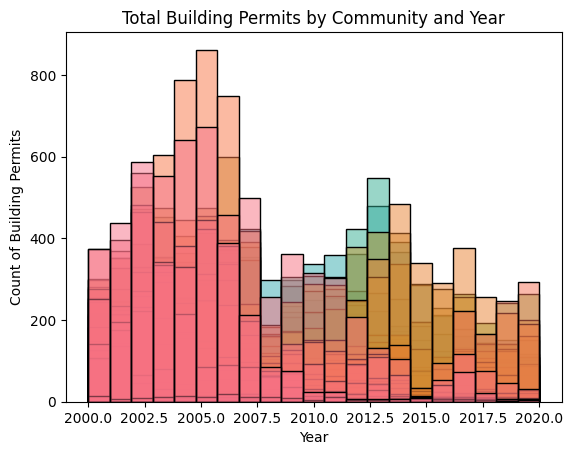

In [26]:
# Histogram
fig = sns.histplot(x='Year', hue='CommCode', bins=21, data=pandas_df)
plt.title('Total Building Permits by Community and Year')
fig.set(ylabel='Count of Building Permits')
fig.legend_.remove()
# fig.get_figure().savefig("permit_build1.png", format='png', dpi=600)

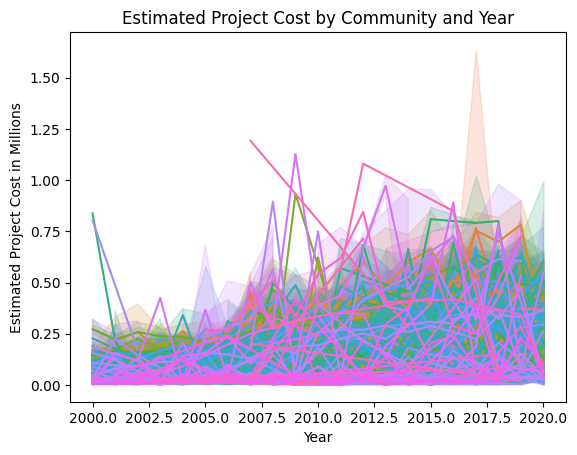

In [27]:
# Line Plot
fig = sns.lineplot(x='Year', y=pandas_df['ProjCost'] /
                   1000000, hue='CommCode', data=pandas_df)
plt.title('Estimated Project Cost by Community and Year')
fig.set(ylabel='Estimated Project Cost in Millions')
fig.legend_.remove()
plt.ticklabel_format(style='plain', axis='y')
# fig.get_figure().savefig("permit_build2.png", format='png', dpi=600)

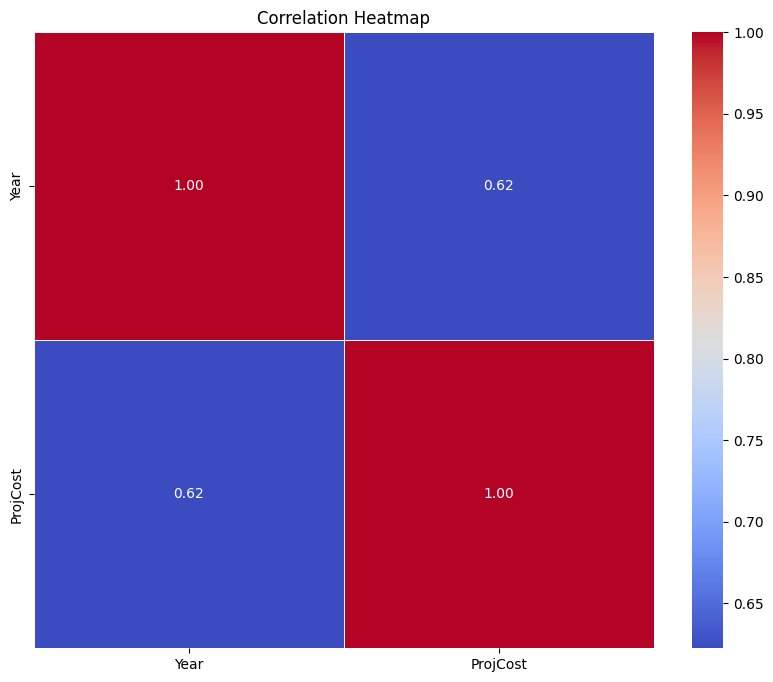

In [28]:
# Drop the non-numeric columns
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
df_EDA = df.drop('CommCode')

# Combine features into a single vector column
vector_assembler = VectorAssembler(
    inputCols=df_EDA.columns, outputCol="features")
df_vectorized = vector_assembler.transform(df_EDA)

# Compute correlation matrix
corr_matrix = Correlation.corr(df_vectorized, "features").head()

# Extract correlation matrix from the result
matrix = corr_matrix[0].toArray()

# Convert to Pandas DataFrame
corr_df = pd.DataFrame(matrix, columns=df_EDA.columns, index=df_EDA.columns)

# Plot heatmap using seaborn

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")

plt.show()

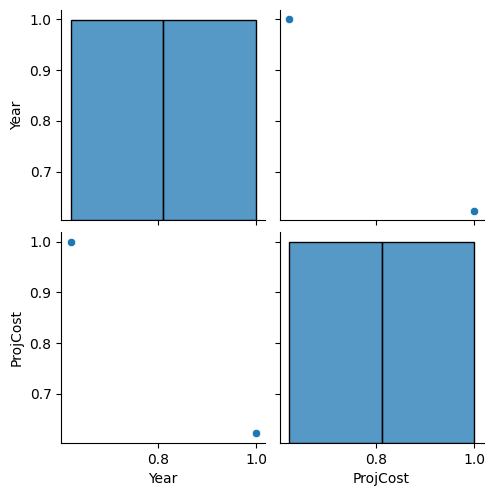

In [29]:
# Combine features into a single vector column
import pandas as pd
vector_assembler = VectorAssembler(
    inputCols=df_EDA.columns, outputCol="features")
df_vectorized = vector_assembler.transform(df_EDA)

# Compute correlation matrix
corr_matrix = Correlation.corr(df_vectorized, "features").head()

# Extract correlation matrix from the result
matrix = corr_matrix[0].toArray()

# Convert to Pandas DataFrame
corr_df = pd.DataFrame(matrix, columns=df_EDA.columns, index=df_EDA.columns)

# Pairplot
sns.pairplot(corr_df, kind='scatter')

plt.show()

In [30]:
num_rows = df.count()
print(f"Number of rows in final dataset: {num_rows}")

Number of rows in final dataset: 111578


In [33]:
# Stop the SparkContext
sc.stop()